# Local sensitivity analysis and difference approximation

Created by Jialu Wang (jwang44@nd.edu)

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.sparse as sparse
import scipy.sparse.linalg as linalg
import scipy.integrate as integrate
import math

## Simple ADR example 

The steady advection-diffusion-reaction(ADR) equation in one-spatial dimension with a spatially constant, but uncertain, diffusion coefficient, a linear reaction term, and a prescribed uncertain source.

$$
\nu \frac{du}{dx} - \omega \frac{d^2u}{dx^2} + \kappa(x)u = S(x)
$$

The QoI is total reaction rate: 
$$
Q= \int^{10}_{0} \kappa(x_ u)(x)dx
$$

In [3]:
def ADRSource(Lx, Nx, Source, omega, v, kappa):
    '''
    Solve the ADR example with algorithm 4.1 from the textbook
    
    Arguments:
        Lx: the scale of x is [0, Lx]
        Nx: the number of points in x scale
        Source: S(x)
        omega: the diffusion coefficient
        v: the convection term constant
        kappa: the linear reaction term coefficient
        
    Return:
        Solution: u 
        Q: QoI, the total reaction rate 
    '''
    #Solves the diffusion equation
    A = sparse.dia_matrix((Nx,Nx),dtype="complex")
    dx = Lx/Nx
    i2dx2 = 1.0/(dx*dx)
    
    #fill diagonal of A
    A.setdiag(2*i2dx2*omega + np.sign(v)*v/dx + kappa)
    
    #fill off diagonals of A
    A.setdiag(-i2dx2*omega[1:Nx] + 
              0.5*(1-np.sign(v[1:Nx]))*v[1:Nx]/dx,1)
    
    A.setdiag(-i2dx2*omega[0:(Nx-1)] - 
              0.5*(np.sign(v[0:(Nx-1)])+1)*v[0:(Nx-1)]/dx,-1)
    
    #solve A x = Source
    Solution = linalg.spsolve(A,Source)
    Q = integrate.trapz(Solution*kappa,dx=dx)
    return Solution, Q

In [4]:
# q: mean, variance, function
q_nom = 1
q_var = 7.062353e-4
Source_func = lambda x, q:  q*x*(10-x)

# kappa: mean, variance, function
kappal_nom = 0.1
kappal_var = 8.511570e-6
kappah_nom = 2
kappah_var = 0.002778142
kappa_func = lambda x, kappal, kappah: kappah + (kappal-kappah)*(x>5)*(x<7.5)

# v: mean, variance, function
v_nom = 10
v_var = 0.0723493
v_func = lambda x,v: v*np.ones(x.size)

# omega: mean, variance, function
omega_nom = 20
omega_var = 0.3195214
omega_func = lambda x,omega: omega*np.ones(x.size)


# define the scale of x 
Lx = 10
Nx = 2000
dx = Lx/Nx
xs = np.linspace(dx/2,Lx-dx/2,Nx)

# Calculating Q with the mean value of parameters
source = Source_func(xs, 1)
kappa = kappa_func(xs, 0.1, 2)
vs = v_func(xs, v_nom)
omegas = omega_func(xs, omega_nom)

sol,Q = ADRSource(Lx, Nx, source, omegas, vs, kappa)
print(Q)

(52.390252927707564+0j)


/Users/a/anaconda3/lib/python3.7/site-packages/scipy/sparse/linalg/dsolve/linsolve.py:133: SparseEfficiencyWarning: spsolve requires A be CSC or CSR matrix format
  SparseEfficiencyWarning)


## First-order sensitivity approximation

Forward difference derivative approximation:

$\frac{\partial Q}{\partial x_i} \bigg|_{\overline{x}} \approx \frac{Q(\overline{x} + \delta_i\hat{e_i}) - Q(\overline{x})}{\delta_i}$

Central difference derivative approximation:

$\frac{\partial Q}{\partial x_i} \bigg|_{\overline{x}} \approx \frac{Q(\overline{x} + 0.5\delta_i\hat{e_i}) - Q(\overline{x} - 0.5\delta_i\hat{e_i})}{\delta_i}$

The complex step formula: 

$\frac{\partial Q}{\partial x_i} \bigg|_{\overline{x}} \approx \frac{\mathscr{I} \{Q(\overline{x} + i\delta_i \hat{e_i})\}}{\delta_i} + O(\delta_i^2)$

/Users/a/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:23: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/a/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:35: ComplexWarning: Casting complex values to real discards the imaginary part


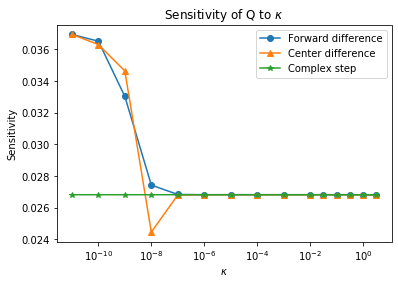

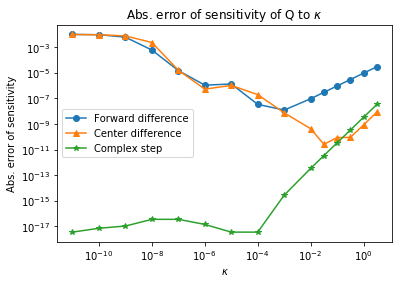

In [5]:
deltas = 10.**np.array([1.5,1,0.5,0,-0.5,-1,-2,-3,-4,-5,-6,-7,-8,-9,-10])

# store forward difference results
sens_FD = np.zeros(deltas.size)

# store central difference results
sens_CD = np.zeros(deltas.size)

# store complex step approximation results
sens_CS = np.zeros(deltas.size)

# Q calculated from the mean value of parameters
Q_nom = Q

# kappa value in the x scale 
mean_kappa = kappa_func(xs, kappal_nom, kappah_nom)

# Calculate the sensitivity at each delta
for count, delta in enumerate(deltas):
    i = 1250
    
    # Get sensitivity from forward difference 
    pert = np.ones(Nx)
    pert[i] += (delta)
    sol, Qnew = ADRSource(Lx, Nx, Source_func(xs, q_nom), omega_func(xs, omega_nom), v_func(xs, v_nom),
                              mean_kappa*pert)
    sens_FD[count] = (Qnew - Q_nom)/(delta*mean_kappa[i])
    
    # Get sensitivity from central difference
    pert = np.ones(Nx)
    pert[i] += (delta/2)
    sol, Qfor = ADRSource(Lx, Nx, Source_func(xs, q_nom), omega_func(xs, omega_nom), v_func(xs, v_nom),
                              mean_kappa*pert)
    
    pert = np.ones(Nx)
    pert[i] += (-delta/2)
    sol, Qback = ADRSource(Lx, Nx, Source_func(xs, q_nom), omega_func(xs, omega_nom), v_func(xs, v_nom),
                              mean_kappa*pert)
    sens_CD[count] = (Qfor - Qback)/(delta*mean_kappa[i])
    
    # Get sensitivity from the complex step approximation
    pert = np.ones(Nx,dtype="complex")
    pert[i] += (delta*1j)
    sol, Qnew = ADRSource(Lx, Nx, Source_func(xs, q_nom), omega_func(xs, omega_nom), v_func(xs, v_nom),
                          mean_kappa*pert)
    sens_CS[count] = np.imag(Qnew)/(delta*mean_kappa[i])


# Calculate the sensitivity with complex step, delta=1E-12 as the exact sensitivity
delta_c = 1e-12
pert = np.ones(Nx,dtype="complex")
pert[i] += (delta_c*1j)
sol, Qnew = ADRSource(Lx, Nx, Source_func(xs, q_nom), omega_func(xs, omega_nom), v_func(xs, v_nom),
                      mean_kappa*pert)
exact = np.imag(Qnew)/(delta_c*mean_kappa[i])

# Sensitivity plot 
plt.semilogx(deltas*mean_kappa[i], sens_FD,'o-', label='Forward difference')
plt.plot(deltas*mean_kappa[i], sens_CD,'^-', label='Center difference')
plt.plot(deltas*mean_kappa[i], sens_CS,'*-', label='Complex step')
plt.ylabel('Sensitivity')
plt.xlabel('$\kappa$')
plt.title('Sensitivity of Q to $\kappa$')
plt.legend()
plt.show()

# Absolute error plot
plt.loglog(deltas*mean_kappa[i], np.abs(exact-sens_FD),'o-', label='Forward difference')
plt.loglog(deltas*mean_kappa[i], np.abs(exact-sens_CD),'^-', label='Center difference')
plt.loglog(deltas*mean_kappa[i], np.abs(exact-sens_CS),"*-", label='Complex step')
plt.ylabel('Abs. error of sensitivity')
plt.xlabel('$\kappa$')
plt.title('Abs. error of sensitivity of Q to $\kappa$')
plt.legend()
plt.show()

## Second-Derivative approximations

The second derivative: 

$\frac{\partial^2 Q}{\partial x_i^2} \bigg|_{\overline{x}} \approx \frac{Q(\overline{x} + \delta_i\hat{e_i}) - 2Q(\overline{x}) + Q(\overline{x} - \delta_i\hat{e_i})}{\delta_i^2}$


In [7]:
# Get Q value with average value of parameters
xs = np.linspace(dx/2,Lx-dx/2,Nx)
source = Source_func(xs, 1)
kappa = kappa_func(xs, 0.1, 2)

omega_nom = 20
omega_var = 0.3195214
v_nom = 10
v_var = 0.0723493
kappal_nom = 0.1
kappal_var = 8.511570e-6
kappah_nom = 2
kappah_var = 0.002778142
q_nom = 1
q_var = 7.062353e-4
vs = v_func(xs, v_nom)

# Q(x) needs to be evaluated only once 
sol,q_center = ADRSource(Lx, Nx, Source_func(xs, q_nom), omega_func(xs, omega_nom), 
                                 vs,                       
                                 kappa_func(xs, kappal_nom, kappah_nom))  

# define perturbation
delta = 1e-4

sens_q2 = np.zeros(5)

# loop over each parameter 
for i in range(5):
    deltas = np.zeros(5)
    # only one parameter is perturbed
    deltas[i] = 1.0*delta
        
    # get the forward term 
    sol,forward_pert = ADRSource(Lx, Nx, Source_func(xs, q_nom*(1+deltas[4])), omega_func(xs, omega_nom*(1+deltas[1])), 
                                 vs*(1+deltas[0]),                       
                                 kappa_func(xs, kappal_nom*(1+deltas[2]), kappah_nom*(1+deltas[3])))  
    
    # get the backward term
    sol,backward_pert = ADRSource(Lx, Nx, Source_func(xs, q_nom*(1-deltas[4])), omega_func(xs, omega_nom*(1-deltas[1])), 
                                 vs*(1-deltas[0]),                       
                                 kappa_func(xs, kappal_nom*(1-deltas[2]), kappah_nom*(1-deltas[3])))
    
    noms = np.array((v_nom,omega_nom,kappal_nom, kappah_nom, q_nom))
    
    # the second derivative for the perturbed parameter 
    sens_q2[i] = (forward_pert - 2*q_center + backward_pert)/(np.sum(noms*deltas))**2
    
print('The second derivative for the five parameters are', sens_q2*noms*noms)

The second derivative for the five parameters are [ 3.55503929e+00  9.36436493e+00  7.08268999e-02 -2.06039637e+01
 -7.10542736e-06]


/Users/a/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:45: ComplexWarning: Casting complex values to real discards the imaginary part
